**Detection of Covid-19 Using X-ray Image by Muhammad Umair Ali (BC170404280)**

The goal of the proposed project called “Detection of Covid-19 Using X-Ray Images” is to develop an automatic detection system to detect covid-19.In this software, we intend to use the chest x-ray for the detection of coronavirus infected patients in an automated manner. This system will be helpful to hospital doctors for early identifying patients with high likelihood of Coronavirus.

**Mount Google Drive to access Dataset**

1.Executing the below code which will provide you with an authentication link.

 2.Open the link.
 
  3.Choose the Google account whose Drive you want to mount.
  
   4.Allow Google Drive Stream access to your Google Account

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing all the prerequisite Libraries

In [2]:
from __future__ import print_function, division  #to enable new language features compatible e.g 11/4=2.75
from builtins import range, input  #provides direct access to  ‘built-in’ identifiers of Python e.g range, input functions

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout #application-specific layers
from tensorflow.keras.models import Model, load_model  # for loading saved model after training
from tensorflow.keras.applications.resnet50 import ResNet50 # importing pre-trained CNN model ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input  #for pre-processing image data e.g  BGR image to RGB
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # to generate batches of tensor image data

from sklearn.metrics import confusion_matrix, roc_curve # to measure classification performance
import seaborn as sns #for making statistical graphics and to produce informative plots
import numpy as np  #for working with Arrays e.g to perform mathematical operations on Arrays
import matplotlib.pyplot as plt  # for creating plotting area in a figure, plotting images
import cv2 # to read images, Resize images,
from glob import glob #to access or retrieve files and pathnamess e.g to get only files with 'jpg','jpeg' extensions
from sklearn.model_selection import train_test_split # to split data into train and test
from sklearn.preprocessing import LabelBinarizer # to label either 0 or 1
from tensorflow.keras.utils import to_categorical #

### Defining some Parameters

In [3]:
#Resizing all the  images to the same size 
IMAGE_SIZE = [224, 224] # 224 x 224 is the width and height 

# training configuration:
epochs = 100
batch_size = 25

#defining  paths for dataset
covid_path = '/content/drive/MyDrive/Final Year Project_Saeed/dataset/chest x_rays/Covid'
normal_path = '/content/drive/MyDrive/Final Year Project_Saeed/dataset/chest x_rays/Normal'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
normal_files = glob(normal_path + '/*')

### Fetching Images and Labelling class from Files

In [4]:
# Preparing Labels for dataset (Covid and Normal)
covid_labels = []
normal_labels = []

covid_images=[]
normal_images=[]


for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # method to convert a BGR image to RGB
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Covid') 
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # method to convert a BGR image to RGB
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('Normal')

### Visualizing First 30 Images from the Data set

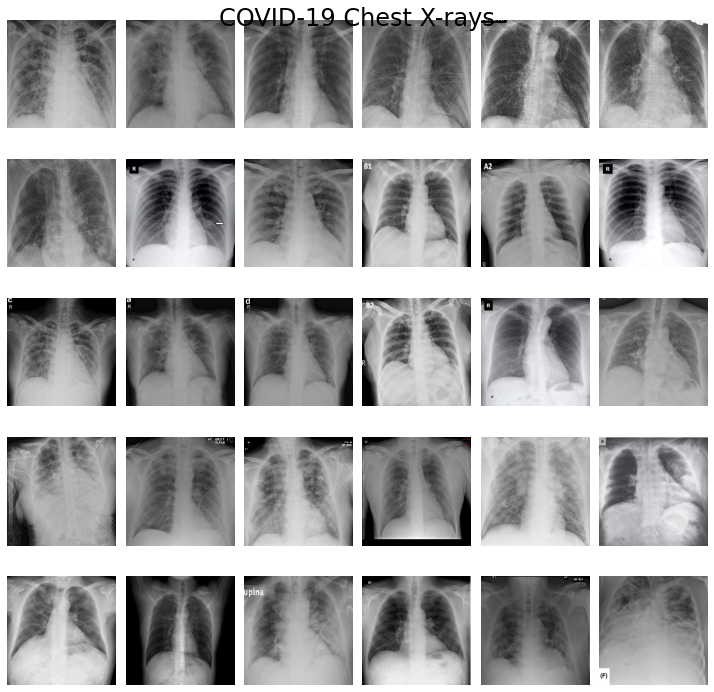

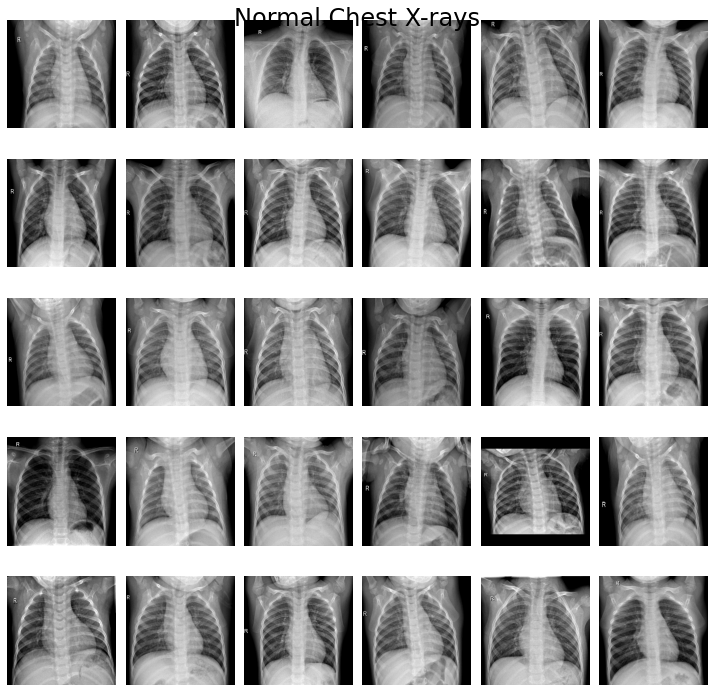

In [5]:
# look at random images
def plot_images(images, title):
    nrows, ncols = 5, 6
    figsize = [10, 10]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=1, rect=[0, 0, 1, 1])
    plt.show()
plot_images(covid_images, 'COVID-19 Chest X-rays')
plot_images(normal_images, 'Normal Chest X-rays')

### **Preprocessing with Image Normalization**

 **Model takes images in the form of array of pixels. Hence convert into array and normalize**

In [6]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255

### **Dataset Splitting inTrain & Test**

In [7]:

# splitting into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

# making labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### **Visualizing some images from Training and Test sets**

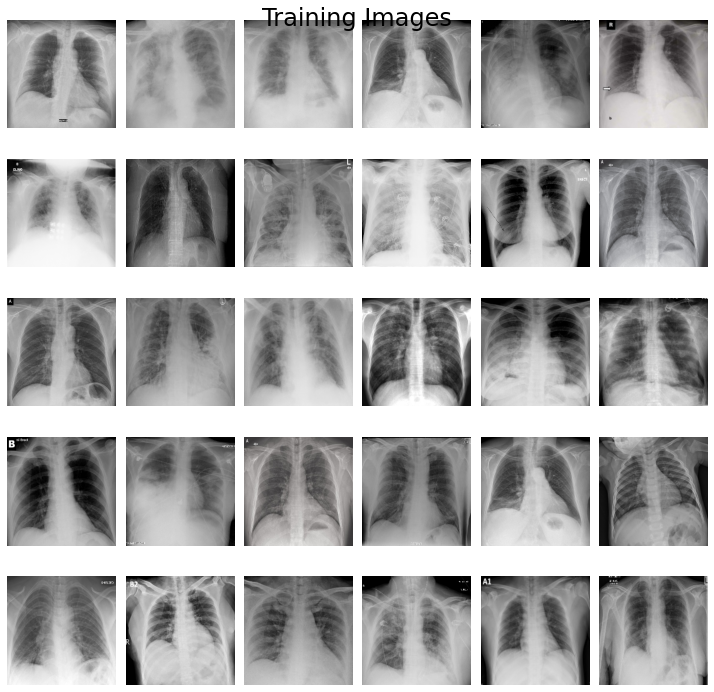

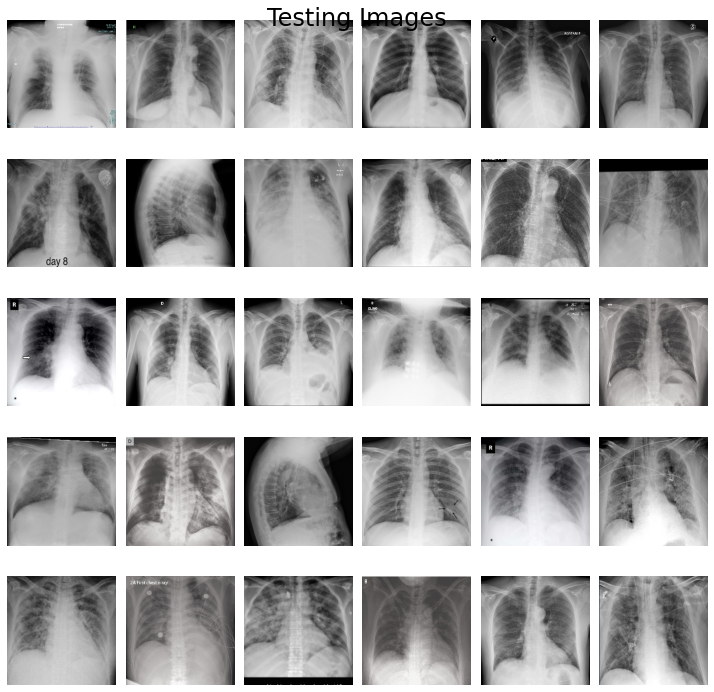

In [8]:
plot_images(covid_x_train, 'Training Images')
plot_images(covid_x_test, 'Testing Images')
# y_train and y_test contain class lables 0 and 1 representing COVID and Normal for X_train and X_test

### **Building model (Using Pre trained CNN Model ResNet50)**

![image.png](attachment:image.png)

In [9]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Summarizing Model**

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### **Training CNN model on our own dataset**

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=25),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 25,
                    steps_per_epoch=len(X_train) / 25,
                    epochs=100)

Epoch 1/100
30/30 [==============================] - 14s 469ms/step - loss: 1.8263 - accuracy: 0.6081 - val_loss: 0.8609 - val_accuracy: 0.5959
Epoch 2/100
30/30 [==============================] - 12s 400ms/step - loss: 0.6813 - accuracy: 0.7383 - val_loss: 1.0329 - val_accuracy: 0.6010
Epoch 3/100
30/30 [==============================] - 12s 398ms/step - loss: 0.5121 - accuracy: 0.8086 - val_loss: 0.1519 - val_accuracy: 0.9430
Epoch 4/100
30/30 [==============================] - 12s 398ms/step - loss: 0.3834 - accuracy: 0.8620 - val_loss: 0.1624 - val_accuracy: 0.9430
Epoch 5/100
30/30 [==============================] - 12s 404ms/step - loss: 0.3806 - accuracy: 0.8724 - val_loss: 0.1723 - val_accuracy: 0.9430
Epoch 6/100
30/30 [==============================] - 12s 398ms/step - loss: 0.5452 - accuracy: 0.8411 - val_loss: 0.3710 - val_accuracy: 0.8808
Epoch 7/100
30/30 [==============================] - 12s 399ms/step - loss: 0.3632 - accuracy: 0.8737 - val_loss: 0.1227 - val_accuracy:

### **Saving the trained model**

In [13]:
model.save('/content/drive/MyDrive/Final Year Project_Saeed/models/resnet_chest.h5')

In [15]:
model.save_weights('/content/drive/MyDrive/Final Year Project_Saeed/models/resnetweights_chest.hdf5')

###  **Load an already saved model (If there is a trained model already saved on drive)**

In [16]:
model = load_model('/content/drive/MyDrive/Final Year Project_Saeed/models/resnet_chest.h5')

### **Making Predicions**

In [17]:
y_pred = model.predict(X_test, batch_size=batch_size)

### **Displaying First 5 predictions**

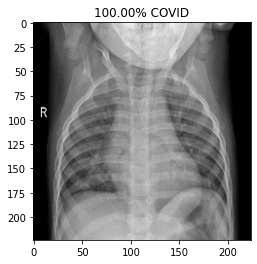

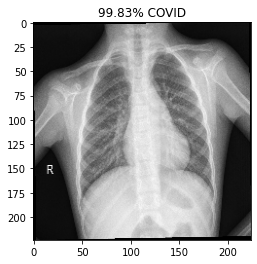

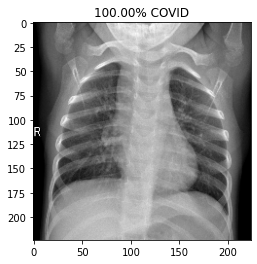

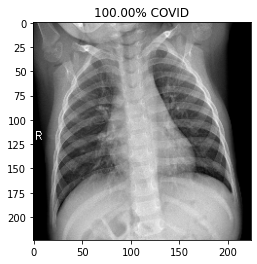

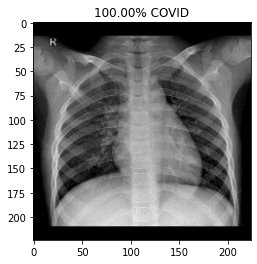

In [18]:
prediction=y_pred[0:5]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Normal')
  plt.imshow(X_test[index])
  plt.show()

In [19]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### **Plotting ROC Curve (receiver operating characteristic curve)**

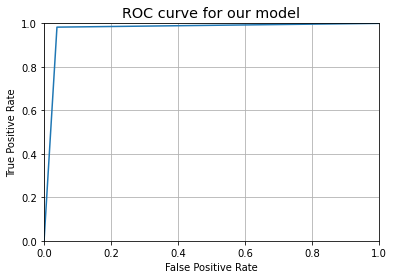

In [20]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### **Plotting Confusion Matrix**

Confusion Matrix without Normalization


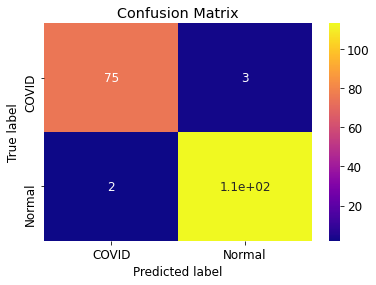

Confusion Matrix with Normalized Values


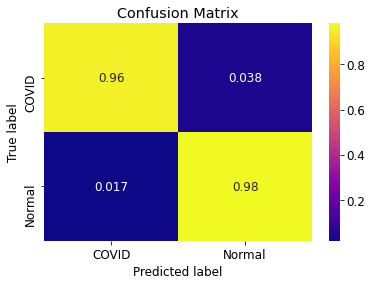

In [22]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','Normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report of Model**

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        78
           1       0.97      0.98      0.98       115

    accuracy                           0.97       193
   macro avg       0.97      0.97      0.97       193
weighted avg       0.97      0.97      0.97       193



### **Accuracy and Loss Plots**

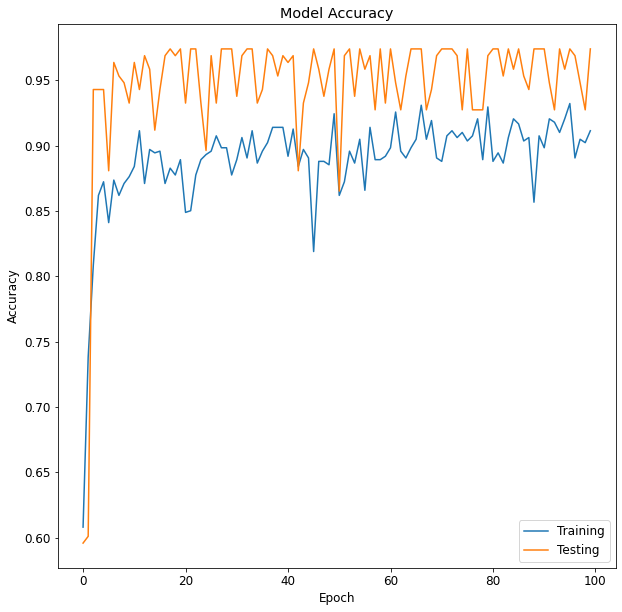

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


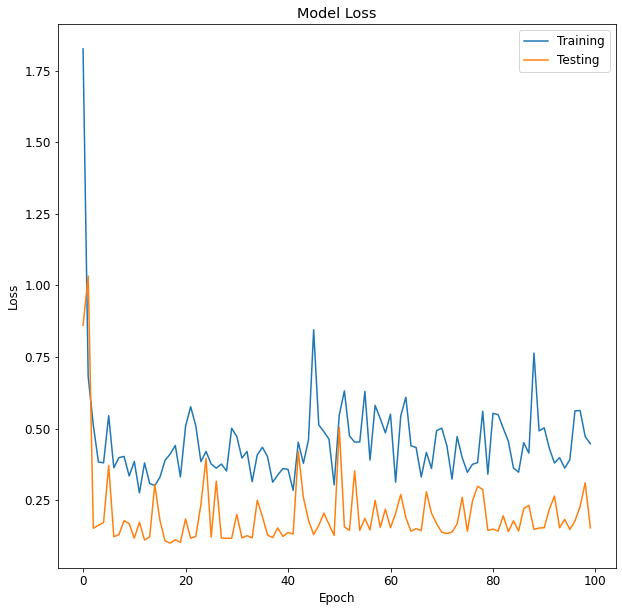

In [25]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()